In [1]:
from utils import *
import numpy as np
import matplotlib.pyplot as plt
import pyqpanda as pq
import pyvqnet as pv
import random

%matplotlib inline

In [2]:
train_data = Dataset(
    "data/cifar-10-batches-py/data_batch_1",
    "data/cifar-10-batches-py/data_batch_2",
    "data/cifar-10-batches-py/data_batch_3",
    "data/cifar-10-batches-py/data_batch_4",
    "data/cifar-10-batches-py/data_batch_5",
)
train_data.enhance()
test_data = Dataset("data/cifar-10-batches-py/test_batch")

In [3]:
class Model(pv.nn.module.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.relu = pv.nn.ReLu()
        self.conv1 = pv.nn.Conv2D(3, 16, (3, 3), padding="same")
        self.pool1 = pv.nn.MaxPool2D((4, 4), (4, 4))
        self.conv2 = pv.nn.Conv2D(16, 16, (3, 3), padding="same")
        self.pool2 = pv.nn.MaxPool2D((4, 4), (4, 4))
        self.fc1 = pv.nn.Linear(64, 32)
        self.fc2 = pv.nn.Linear(32, 16)
        self.fc3 = pv.nn.Linear(16, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)  # -> 16 * 8 * 8
        x = self.conv2(x)
        x = self.pool2(x)  # -> 16 * 2 * 2
        # print(x.shape)
        x = pv.tensor.flatten(x, 1)  # -> 64
        x = self.fc1(x)
        x = self.relu(x)  # -> 32
        x = self.fc2(x)
        x = self.relu(x)  # -> 16
        x = self.fc3(x)  # -> 10
        return x

In [4]:
epoch = 1000
batch = 8
holdout = 10000

model = Model()
# model.load_state_dict(pv.utils.storage.load_parameters("train15.model"))
print(sum(p.numel() for p in model.parameters()))

e = 1
acc_train = []
acc_test = []

5546


In [5]:
# batch = 128

In [6]:
X, Y = train_data.getdatas()
los = pv.nn.loss.CrossEntropyLoss()
opt = pv.optim.SGD(model.parameters())
# opt = pv.optim.Adam(model.parameters())

while e <= epoch:
    model.train()

    correct_tot = 0
    for I, (x, y) in enumerate(
        pv.data.data_generator(
            X[:-holdout], Y[:-holdout], batch_size=batch, shuffle=True
        )
    ):
        i = I + 1
        # print(i)
        opt.zero_grad()
        y_pred = model(x)
        loss = los(y, y_pred)
        correct = sum(y_pred.argmax(1, False).to_numpy() == y)
        acc = correct / y.shape[0]
        correct_tot += correct
        loss.backward()
        opt._step()
        if i % 1000 == 0:
            print(
                f"epoch {e}/{epoch} \t batch {batch*i}/{Y.shape[0]-holdout} \t loss {loss.item():.2f} \t accuracy {acc:.2f}"
            )
    e += 1

    model.eval()

    acc = correct_tot / (Y.shape[0] - holdout)
    print(f"********** train: epoch {e}/{epoch} \t accuracy {100*acc:.2f}% **********")
    acc_train.append(acc)

    correct_tot = 0
    for x, y in pv.data.data_generator(
        X[-holdout:], Y[-holdout:], batch_size=128, shuffle=False
    ):
        y_pred = model(x)
        correct_tot += sum(y_pred.argmax(1, False).to_numpy() == y)

    acc = correct_tot / holdout
    print(f"********** test : epoch {e}/{epoch} \t accuracy {100*acc:.2f}% **********")
    acc_test.append(acc)

    opt = pv.optim.SGD(model.parameters(), 0.01 * (1 - acc))

epoch 1/1000 	 batch 8000/90000 	 loss 2.27 	 accuracy 0.25
epoch 1/1000 	 batch 16000/90000 	 loss 2.26 	 accuracy 0.25
epoch 1/1000 	 batch 24000/90000 	 loss 1.72 	 accuracy 0.38
epoch 1/1000 	 batch 32000/90000 	 loss 2.02 	 accuracy 0.12
epoch 1/1000 	 batch 40000/90000 	 loss 2.14 	 accuracy 0.38
epoch 1/1000 	 batch 48000/90000 	 loss 2.33 	 accuracy 0.25
epoch 1/1000 	 batch 56000/90000 	 loss 1.85 	 accuracy 0.25
epoch 1/1000 	 batch 64000/90000 	 loss 1.58 	 accuracy 0.38
epoch 1/1000 	 batch 72000/90000 	 loss 1.18 	 accuracy 0.62
epoch 1/1000 	 batch 80000/90000 	 loss 1.75 	 accuracy 0.50
epoch 1/1000 	 batch 88000/90000 	 loss 1.26 	 accuracy 0.75
********** train: epoch 2/1000 	 accuracy 31.92% **********
********** test : epoch 2/1000 	 accuracy 45.57% **********
epoch 2/1000 	 batch 8000/90000 	 loss 0.94 	 accuracy 0.88
epoch 2/1000 	 batch 16000/90000 	 loss 2.99 	 accuracy 0.00
epoch 2/1000 	 batch 24000/90000 	 loss 1.13 	 accuracy 0.38
epoch 2/1000 	 batch 32000/9

KeyboardInterrupt: 

In [7]:
pv.utils.storage.save_parameters(model.state_dict(), "raw.model")

In [8]:
m = Model()
m.load_state_dict(pv.utils.storage.load_parameters("raw.model"))

In [9]:
m.eval()
X, Y = test_data.getdatas()
correct_tot = 0
for x, y in pv.data.data_generator(X, Y, batch_size=128, shuffle=False):
    y_pred = model(x)
    correct_tot += sum(y_pred.argmax(1, False).to_numpy() == y)
acc = correct_tot / Y.shape[0]
print(f"********** eval : accuracy {100*acc:.2f}% **********")

********** eval : accuracy 67.21% **********


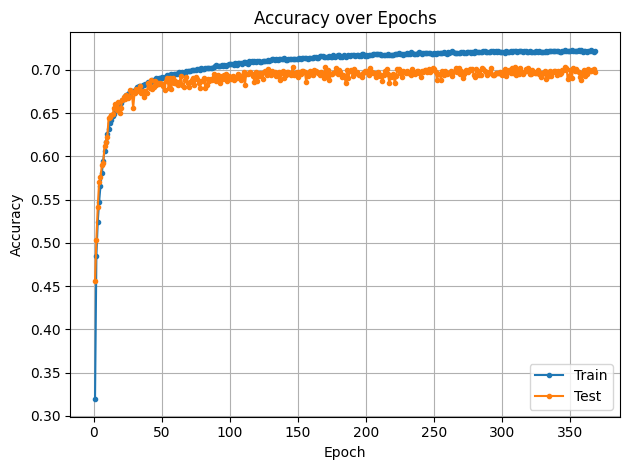

In [19]:
epochs = range(1, len(acc_train) + 1)

plt.plot(epochs, acc_train, label="Train", marker=".")
plt.plot(epochs, acc_test, label="Test", marker=".")

plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()
#plt.ylim((0,1))
plt.tight_layout()

#plt.savefig("raw.png")
plt.show()


<Figure size 640x480 with 0 Axes>